In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import rcParams

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [3]:
# Bengali Handwritten Character Recognition using Ekush Dataset
# Complete Implementation in Jupyter Notebook

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Step 1: Define paths and parameters
# You'll need to update these paths according to your dataset location
BASE_PATH = r'C:\Users\KIIT\Desktop\minor\dataset\dataset'  # Update this path
METADATA_PATH = os.path.join(BASE_PATH, r"C:\Users\KIIT\Desktop\minor\metaData_img.csv")  # Update if filename is different
IMG_SIZE = 28  # We'll resize all images to 64x64
BATCH_SIZE = 28
EPOCHS = 15
NUM_CLASSES = 122  # 122 Bengali character classes (0-121)

# Step 2: Load metadata
# The metadata file maps folder names to actual Bengali characters
metadata = pd.read_csv(METADATA_PATH)
print("Metadata information:")
print(metadata.head())

# Create a mapping from class index to Bengali character name
class_to_char = dict(zip(metadata['Folder Name'].astype(int), metadata['Char Name']))
print(f"Sample mapping - Class 0: {class_to_char[0]}")

TensorFlow version: 2.18.0
GPU Available: []
Metadata information:
   Folder Name Char Name
0            0         া
1            1         ি
2            2         ী
3            3         ু
4            4         ূ
Sample mapping - Class 0:  া


In [7]:
# Step 3: Function to load and preprocess images (Revised)
def load_images(base_path, img_size=IMG_SIZE):
    """
    Load images from the directory structure and preprocess them.
    Assumes images are already grayscale with white characters on black background.

    Args:
        base_path: Path to the dataset
        img_size: Size to resize images to

    Returns:
        X: Image data as numpy array
        y: Labels as numpy array
    """
    X = []
    y = []

    # Loop through each class folder
    for class_idx in range(NUM_CLASSES):
        class_dir = os.path.join(base_path, str(class_idx))
        print(f"Loading class {class_idx}: {class_to_char.get(class_idx, 'Unknown')}")

        # Check if directory exists
        if not os.path.exists(class_dir):
            print(f"Warning: Directory for class {class_idx} not found at {class_dir}")
            continue

        # Get all image files in the class directory
        try:
            img_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
            print(f"Found {len(img_files)} images in class {class_idx}")
        except Exception as e:
            print(f"Error reading directory {class_dir}: {e}")
            continue

        # Optional: Limit the number of images per class for faster development
        # Uncomment for quicker experimentation
        # img_files = img_files[:500]  # Using 500 images per class for faster development

        for img_file in img_files:
            img_path = os.path.join(class_dir, img_file)

            try:
                # Read and preprocess image (maintain original grayscale)
                img = tf.keras.preprocessing.image.load_img(
                    img_path,
                    color_mode='grayscale',
                    target_size=(img_size, img_size)
                )

                # Convert to array and normalize (keep as is, assume already preprocessed)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = img_array / 255.0  # Normalize to [0, 1]

                # Verify image isn't just noise by checking variance or other metrics
                # This can help filter out corrupted images
                if np.var(img_array) > 0.01:  # Adjust threshold as needed
                    X.append(img_array)
                    y.append(class_idx)
                else:
                    print(f"Skipping possible noisy image: {img_path}")

            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
                continue

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print(f"Successfully loaded {len(X)} images with shape {X.shape}")
    print(f"Labels shape: {y.shape}")

    # Add a check to visualize some loaded images to verify correct loading
    if len(X) > 0:
        plt.figure(figsize=(10, 5))
        for i in range(min(5, len(X))):
            plt.subplot(1, 5, i+1)
            plt.imshow(X[i].reshape(img_size, img_size), cmap='gray')
            plt.title(f"Class: {y[i]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    return X, y

Loading class 0:  া
Found 3047 images in class 0
Loading class 1:  ি
Found 3086 images in class 1
Loading class 2:  ী
Found 3081 images in class 2
Loading class 3:  ু
Found 3077 images in class 3
Skipping possible noisy image: C:\Users\KIIT\Desktop\minor\dataset\dataset\3\1_BIK-err_13_1_479.jpg
Loading class 4:  ূ
Found 3064 images in class 4
Loading class 5:  ৃ
Found 2987 images in class 5
Loading class 6:  ে
Found 3087 images in class 6
Loading class 7:  ৈ
Found 3079 images in class 7
Skipping possible noisy image: C:\Users\KIIT\Desktop\minor\dataset\dataset\7\0_KUSH_21_3_220.jpg
Loading class 8:  ো
Found 3081 images in class 8
Loading class 9:  ৌ
Found 3078 images in class 9
Loading class 10:  অ
Found 3065 images in class 10
Loading class 11:  আ
Found 3074 images in class 11
Loading class 12:  ই
Found 3083 images in class 12
Loading class 13:  ঈ
Found 3077 images in class 13
Loading class 14:  উ
Found 3354 images in class 14
Loading class 15:  ঊ
Found 2806 images in class 15
Loading

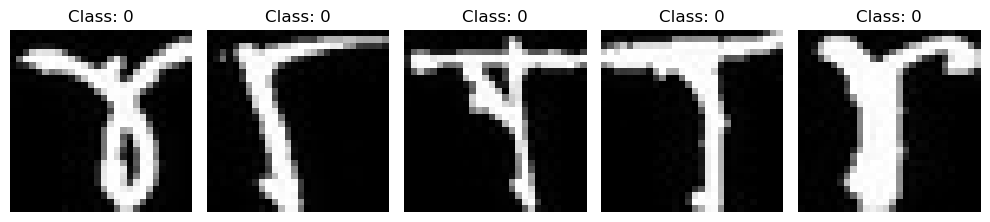

In [9]:
# Step 4: Load and prepare data
# Uncomment the next line when ready to load all data
X, y = load_images(BASE_PATH)

# For demonstration, let's load a small subset (faster for development)
# In practice, you would load the full dataset
# print("Loading a subset of images for demonstration...")
# Simulating loaded data for notebook flow - replace this with actual data loading
# X = np.random.rand(10000, IMG_SIZE, IMG_SIZE, 1)  # Simulated 10,000 images for demonstration
# y = np.random.randint(0, NUM_CLASSES, size=10000)  # Simulated labels
# print(f"Simulated dataset shape: {X.shape}")

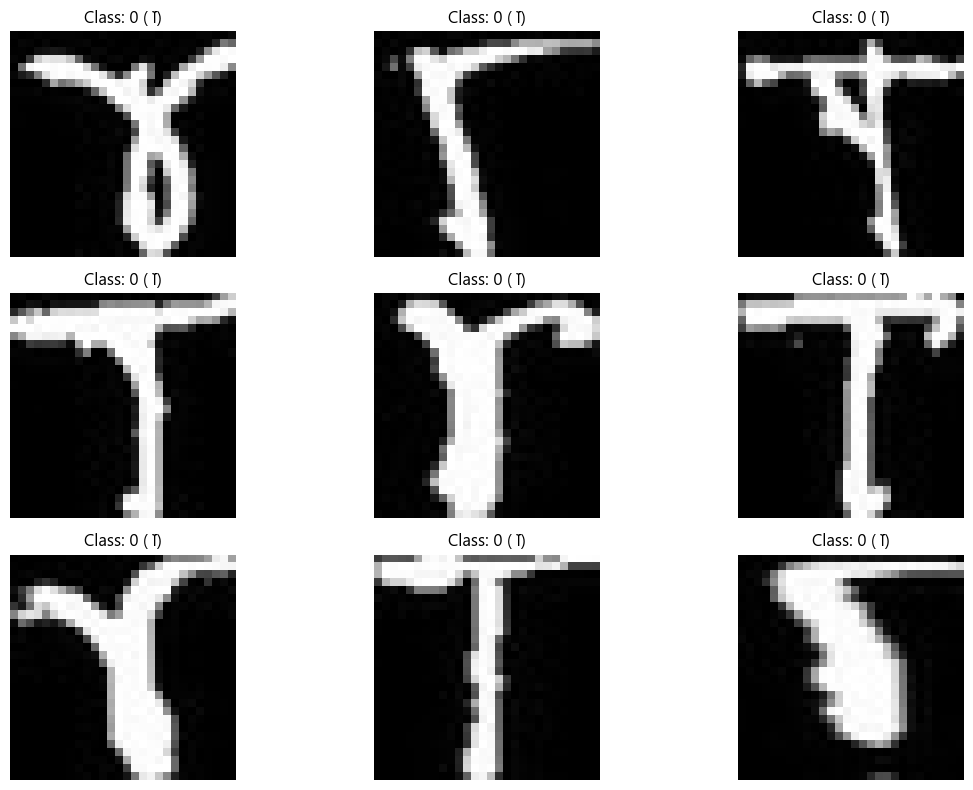

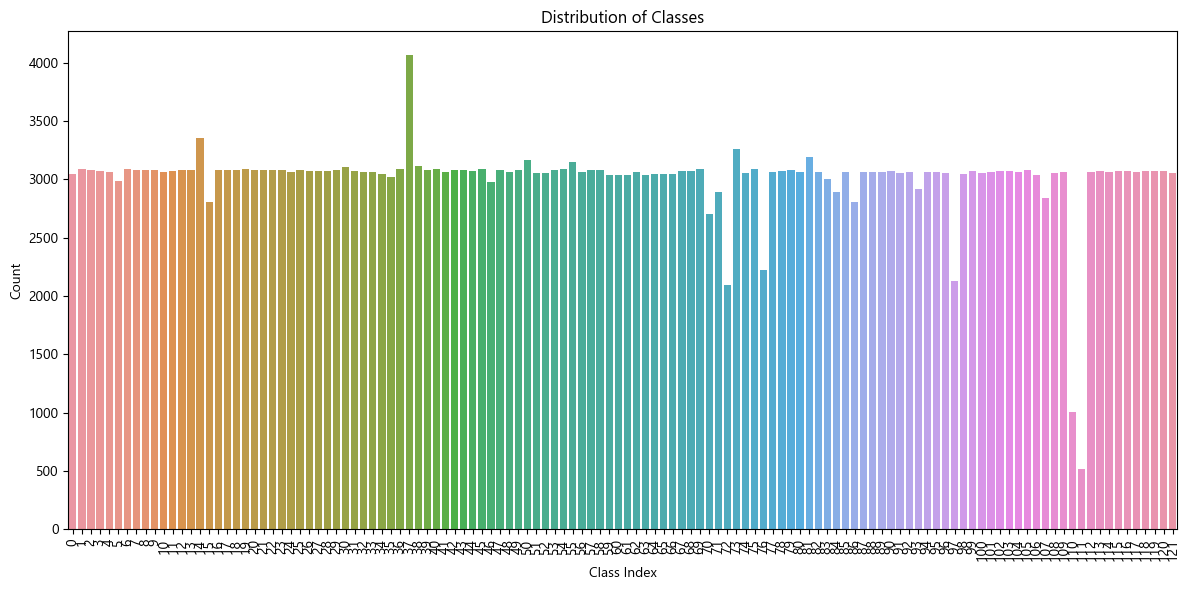

In [127]:
# Step 5: Exploratory Data Analysis
# Visualize some sample images
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    # Display the image
    plt.imshow(X[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    # Add title with class name
    plt.title(f"Class: {y[i]} ({class_to_char.get(y[i], 'Unknown')})")
    plt.axis('off')
plt.tight_layout()
plt.savefig('sample_bengali_characters.png')
plt.show()

# Check class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=y)
plt.title('Distribution of Classes')
plt.xlabel('Class Index')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

In [11]:
# Step 6: Split the dataset
# Convert labels to one-hot encoding
y_categorical = to_categorical(y, num_classes=NUM_CLASSES)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_categorical, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (256895, 28, 28, 1)
Validation set shape: (55049, 28, 28, 1)
Test set shape: (55050, 28, 28, 1)


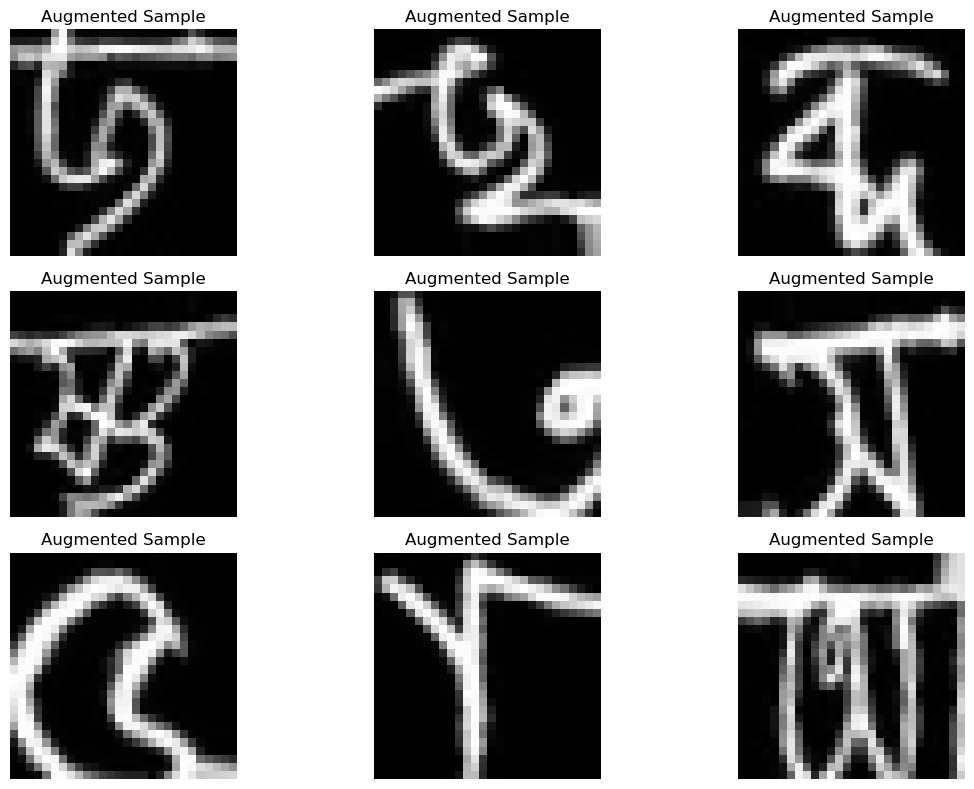

In [12]:
# Step 7: Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=10,  # Small rotations
    width_shift_range=0.1,  # Small horizontal shifts
    height_shift_range=0.1,  # Small vertical shifts
    zoom_range=0.1,  # Small zoom variations
    horizontal_flip=False,  # No horizontal flips for character recognition
    vertical_flip=False,  # No vertical flips for character recognition
    fill_mode='nearest'
)

# Visualize data augmentation examples
plt.figure(figsize=(12, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    batch = data_gen.flow(X_train[i:i+1], y_train[i:i+1], batch_size=1)
    aug_img = next(batch)[0][0]
    plt.imshow(aug_img.reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"Augmented Sample")
    plt.axis('off')
plt.tight_layout()
plt.savefig('augmented_samples.png')
plt.show()

In [13]:
# Step 8: Define the CNN Model
def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 1), num_classes=NUM_CLASSES):
    """
    Create a CNN model for Bengali character recognition.

    This model uses a convolutional neural network architecture specifically designed
    for handwritten character recognition tasks. It includes:
    - Multiple convolutional layers with increasing filter counts
    - BatchNormalization for stable training
    - MaxPooling for dimensionality reduction
    - Dropout for regularization
    - Dense layers for classification

    Args:
        input_shape: Shape of input images
        num_classes: Number of output classes

    Returns:
        Compiled Keras Model
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # First convolutional block
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)

    # Second convolutional block
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Third convolutional block
    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    # Flatten and fully connected layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)

    # Output layer with softmax activation
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the model
model = create_cnn_model()

# Display model summary
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,02

 Total params: 633,562 (2.42 MB)

 Trainable params: 631,898 (2.41 MB)

 Non-trainable params: 1,664 (6.50 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [14]:
# Step 9: Define callbacks for training
callbacks = [
    # Stop training when validation loss stops improving
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when plateauing
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.00001,
        verbose=1
    ),

    # Save the best model during training
    ModelCheckpoint(
        'best_bengali_char_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [15]:
# Step 10: Train the model
history = model.fit(
    data_gen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=20 ,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

C:\Users\KIIT\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
9174/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4896 - loss: 2.1002
Epoch 1: val_accuracy improved from -inf to 0.91417, saving model to best_bengali_char_model.h5


9175/9175 ━━━━━━━━━━━━━━━━━━━━ 469s 50ms/step - accuracy: 0.4897 - loss: 2.1000 - val_accuracy: 0.9142 - val_loss: 0.3222 - learning_rate: 0.0010
Epoch 2/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8380 - loss: 0.5889
Epoch 2: val_accuracy improved from 0.91417 to 0.94103, saving model to best_bengali_char_model.h5


9175/9175 ━━━━━━━━━━━━━━━━━━━━ 485s 53ms/step - accuracy: 0.8380 - loss: 0.5889 - val_accuracy: 0.9410 - val_loss: 0.2282 - learning_rate: 0.0010
Epoch 3/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8725 - loss: 0.4706
Epoch 3: val_accuracy improved from 0.94103 to 0.94725, saving model to best_bengali_char_model.h5


9175/9175 ━━━━━━━━━━━━━━━━━━━━ 485s 53ms/step - accuracy: 0.8725 - loss: 0.4706 - val_accuracy: 0.9472 - val_loss: 0.2053 - learning_rate: 0.0010
Epoch 4/20
9174/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8859 - loss: 0.4155
Epoch 4: val_accuracy improved from 0.94725 to 0.94854, saving model to best_bengali_char_model.h5


9175/9175 ━━━━━━━━━━━━━━━━━━━━ 488s 53ms/step - accuracy: 0.8859 - loss: 0.4155 - val_accuracy: 0.9485 - val_loss: 0.2000 - learning_rate: 0.0010
Epoch 5/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8978 - loss: 0.3784
Epoch 5: val_accuracy improved from 0.94854 to 0.95242, saving model to best_bengali_char_model.h5


9175/9175 ━━━━━━━━━━━━━━━━━━━━ 494s 54ms/step - accuracy: 0.8978 - loss: 0.3784 - val_accuracy: 0.9524 - val_loss: 0.1853 - learning_rate: 0.0010
Epoch 6/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9025 - loss: 0.3587
Epoch 6: val_accuracy improved from 0.95242 to 0.95602, saving model to best_bengali_char_model.h5


9175/9175 ━━━━━━━━━━━━━━━━━━━━ 500s 55ms/step - accuracy: 0.9025 - loss: 0.3587 - val_accuracy: 0.9560 - val_loss: 0.1749 - learning_rate: 0.0010
Epoch 7/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9080 - loss: 0.3397
Epoch 7: val_accuracy did not improve from 0.95602
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 509s 55ms/step - accuracy: 0.9080 - loss: 0.3397 - val_accuracy: 0.9543 - val_loss: 0.1795 - learning_rate: 0.0010
Epoch 8/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9120 - loss: 0.3255
Epoch 8: val_accuracy did not improve from 0.95602
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 523s 57ms/step - accuracy: 0.9120 - loss: 0.3255 - val_accuracy: 0.9549 - val_loss: 0.1746 - learning_rate: 0.0010
Epoch 9/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9158 - loss: 0.3127
Epoch 9: val_accuracy improved from 0.95602 to 0.95898, saving model to best_bengali_char_model.h5


9175/9175 ━━━━━━━━━━━━━━━━━━━━ 524s 57ms/step - accuracy: 0.9158 - loss: 0.3127 - val_accuracy: 0.9590 - val_loss: 0.1632 - learning_rate: 0.0010
Epoch 10/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9180 - loss: 0.3070
Epoch 10: val_accuracy did not improve from 0.95898
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 532s 58ms/step - accuracy: 0.9180 - loss: 0.3070 - val_accuracy: 0.9584 - val_loss: 0.1631 - learning_rate: 0.0010
Epoch 11/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9213 - loss: 0.2943
Epoch 11: val_accuracy improved from 0.95898 to 0.96094, saving model to best_bengali_char_model.h5


9175/9175 ━━━━━━━━━━━━━━━━━━━━ 549s 60ms/step - accuracy: 0.9213 - loss: 0.2943 - val_accuracy: 0.9609 - val_loss: 0.1558 - learning_rate: 0.0010
Epoch 12/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9222 - loss: 0.2909
Epoch 12: val_accuracy did not improve from 0.96094
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 559s 61ms/step - accuracy: 0.9222 - loss: 0.2909 - val_accuracy: 0.9591 - val_loss: 0.1626 - learning_rate: 0.0010
Epoch 13/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9242 - loss: 0.2823
Epoch 13: val_accuracy improved from 0.96094 to 0.96171, saving model to best_bengali_char_model.h5


9175/9175 ━━━━━━━━━━━━━━━━━━━━ 605s 66ms/step - accuracy: 0.9242 - loss: 0.2823 - val_accuracy: 0.9617 - val_loss: 0.1539 - learning_rate: 0.0010
Epoch 14/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9267 - loss: 0.2723
Epoch 14: val_accuracy did not improve from 0.96171
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 608s 66ms/step - accuracy: 0.9266 - loss: 0.2723 - val_accuracy: 0.9613 - val_loss: 0.1542 - learning_rate: 0.0010
Epoch 15/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9262 - loss: 0.2753
Epoch 15: val_accuracy did not improve from 0.96171
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 625s 68ms/step - accuracy: 0.9262 - loss: 0.2753 - val_accuracy: 0.9614 - val_loss: 0.1524 - learning_rate: 0.0010
Epoch 16/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9283 - loss: 0.2631
Epoch 16: val_accuracy did not improve from 0.96171
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 709s 77ms/step - accuracy: 0.9283 - loss: 0.2631 - val_accuracy: 0.9617 - val_loss: 0.1503 - learning_rat

9175/9175 ━━━━━━━━━━━━━━━━━━━━ 747s 81ms/step - accuracy: 0.9296 - loss: 0.2608 - val_accuracy: 0.9633 - val_loss: 0.1465 - learning_rate: 0.0010
Epoch 18/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9298 - loss: 0.2596
Epoch 18: val_accuracy did not improve from 0.96327
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 754s 82ms/step - accuracy: 0.9298 - loss: 0.2596 - val_accuracy: 0.9623 - val_loss: 0.1503 - learning_rate: 0.0010
Epoch 19/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9309 - loss: 0.2596
Epoch 19: val_accuracy improved from 0.96327 to 0.96423, saving model to best_bengali_char_model.h5


9175/9175 ━━━━━━━━━━━━━━━━━━━━ 753s 82ms/step - accuracy: 0.9309 - loss: 0.2596 - val_accuracy: 0.9642 - val_loss: 0.1443 - learning_rate: 0.0010
Epoch 20/20
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9318 - loss: 0.2547
Epoch 20: val_accuracy did not improve from 0.96423
9175/9175 ━━━━━━━━━━━━━━━━━━━━ 735s 80ms/step - accuracy: 0.9318 - loss: 0.2547 - val_accuracy: 0.9619 - val_loss: 0.1494 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 19.


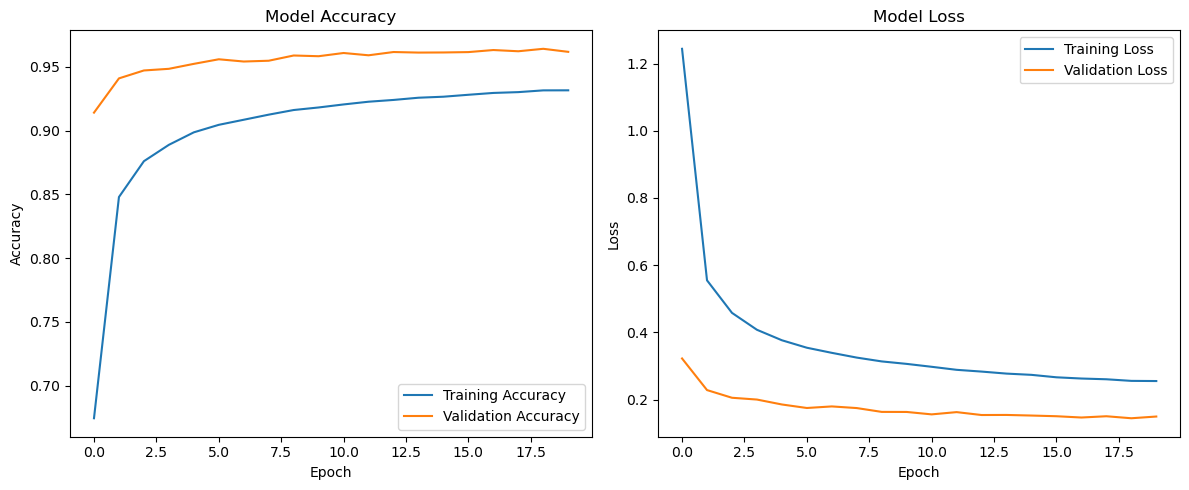

In [16]:
# Step 11: Visualize training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [17]:
# Step 12: Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

1721/1721 ━━━━━━━━━━━━━━━━━━━━ 63s 37ms/step - accuracy: 0.9630 - loss: 0.1516
Test accuracy: 0.9631
Test loss: 0.1536


In [18]:
# Step 13: Make predictions on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

1721/1721 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step


In [19]:
# Step 14: Classification report
print("Classification Report:")
class_report = classification_report(y_true, y_pred)
print(class_report)

# Save the classification report to file
with open('classification_report.txt', 'w') as f:
    f.write(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       441
           1       0.99      0.99      0.99       468
           2       0.96      0.96      0.96       465
           3       0.97      0.95      0.96       470
           4       0.97      0.97      0.97       487
           5       0.99      0.99      0.99       448
           6       0.98      0.97      0.98       483
           7       0.98      0.98      0.98       456
           8       0.98      0.98      0.98       443
           9       0.98      0.98      0.98       427
          10       0.99      0.97      0.98       476
          11       0.98      0.99      0.99       472
          12       0.97      0.98      0.98       442
          13       0.97      0.97      0.97       451
          14       0.94      0.94      0.94       490
          15       0.97      0.96      0.97       405
          16       0.97      0.99      0.98       473
    

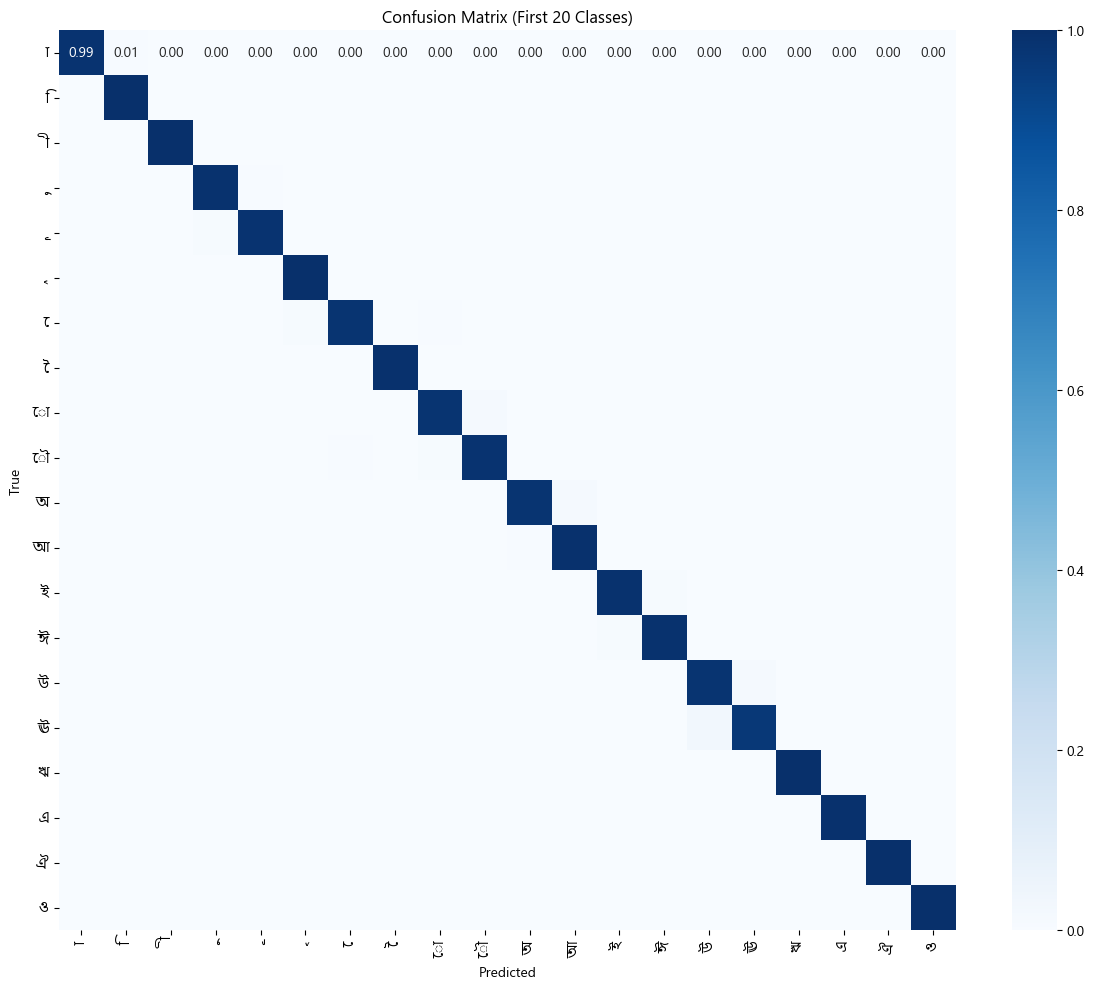

In [129]:
# Step 15: Confusion Matrix (for a subset of classes)
# We'll visualize a subset due to the large number of classes
plt.figure(figsize=(12, 10))
subset_size = 20  # Visualize first 20 classes
subset_indices = np.where((y_true < subset_size) & (y_pred < subset_size))[0]

cm_subset = confusion_matrix(
    y_true[subset_indices],
    y_pred[subset_indices],
    labels=range(subset_size)
)

# Normalize confusion matrix
cm_normalized = cm_subset.astype('float') / cm_subset.sum(axis=1)[:, np.newaxis]

# Create heatmap
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=[class_to_char.get(i, str(i)) for i in range(subset_size)],
    yticklabels=[class_to_char.get(i, str(i)) for i in range(subset_size)]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (First 20 Classes)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

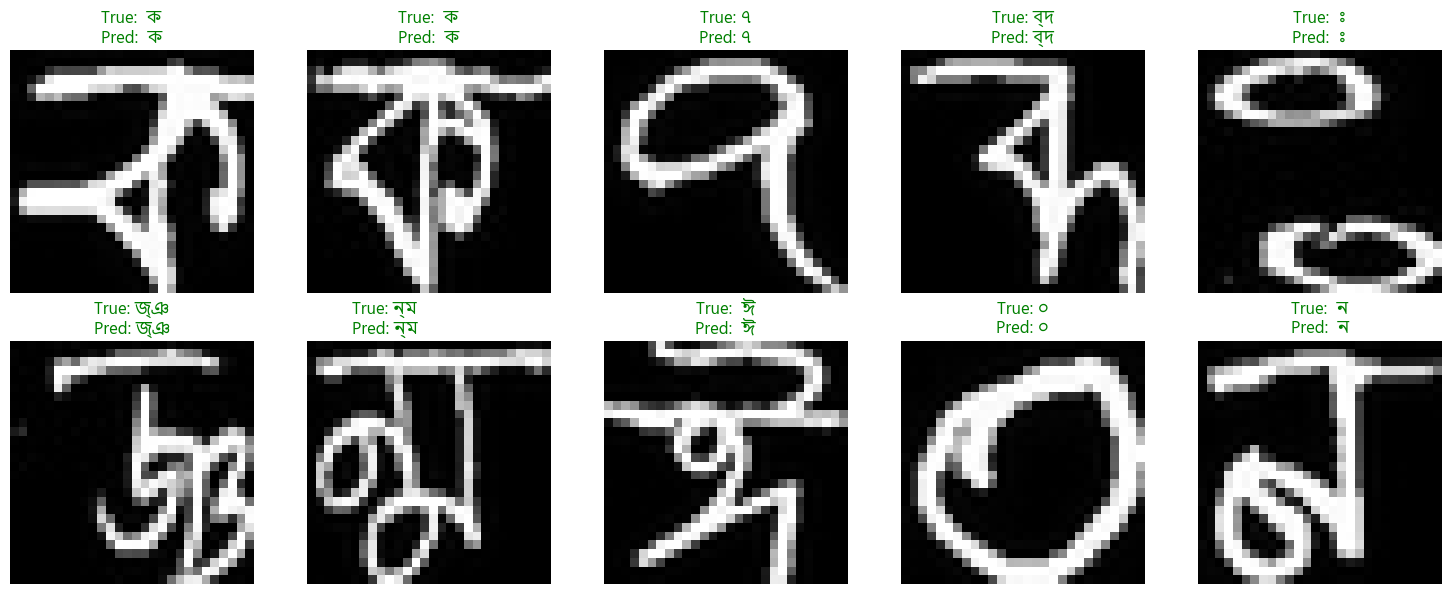

In [ ]:
# Step 16: Visualize some model predictions
def visualize_predictions(X_data, y_true, y_pred, num_samples=10):
    """Visualize model predictions alongside true labels"""
    indices = np.random.choice(len(X_data), num_samples, replace=False)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i+1)
        plt.imshow(X_data[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')

        true_label = class_to_char.get(y_true[idx], str(y_true[idx]))
        pred_label = class_to_char.get(y_pred[idx], str(y_pred[idx]))

        title = f"True: {true_label}\nPred: {pred_label}"
        color = "green" if y_true[idx] == y_pred[idx] else "red"

        plt.title(title, color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.show()

# Visualize predictions
visualize_predictions(X_test, y_true, y_pred)

In [49]:
# Step 17: Save the model for future use
model.save(r"C:\Users\KIIT\Desktop\minor\ekkush_recognition_model.h5")
print("Model saved successfully!")

# Step 18: Create a simple prediction function for new images
def predict_bengali_character(img_path, model):
    """
    Predict the Bengali character from a given image file.

    Args:
        img_path: Path to the image file
        model: Trained model

    Returns:
        predicted_class: The predicted class index
        confidence: Confidence score of the prediction
        character: Bengali character (if mapping available)
    """
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(
        img_path,
        color_mode='grayscale',
        target_size=(IMG_SIZE, IMG_SIZE)
    )

    # Convert to array and normalize
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]

    # Get the Bengali character if available
    character = class_to_char.get(predicted_class, "Unknown")

    # Display results
    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {character} (Class {predicted_class})\nConfidence: {confidence:.4f}")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence, character

# Example usage (uncomment and update path when needed)
# test_img_path = 'path/to/test/image.jpg'
# predicted_class, confidence, character = predict_bengali_character(test_img_path, model)
# print(f"Predicted character: {character} (Class {predicted_class}) with {confidence:.2%} confidence")

Model saved successfully!


In [39]:
plt.rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Noto Sans Bengali', 'Nirmala UI', 'Bangla Sangam MN', 'Lohit Bengali']

# Function to display images with Bengali text
def plot_bengali_predictions(images, true_labels, pred_labels, bengali_chars_dict, rows=2, cols=5, figsize=(15, 8)):
    """
    Plot images with Bengali labels
    
    Parameters:
    images: array of images to display
    true_labels: true class labels (numeric)
    pred_labels: predicted class labels (numeric)
    bengali_chars_dict: dictionary mapping class numbers to Bengali characters
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            ax.axis('off')
            
            true_char = bengali_chars_dict.get(true_labels[i], str(true_labels[i]))
            pred_char = bengali_chars_dict.get(pred_labels[i], str(pred_labels[i]))
            
            # Set title with both correct and predicted labels
            ax.set_title(f'True: {true_char}\nPred: {pred_char}', 
                        color='green' if true_labels[i] == pred_labels[i] else 'red',
                        fontsize=12)
    
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


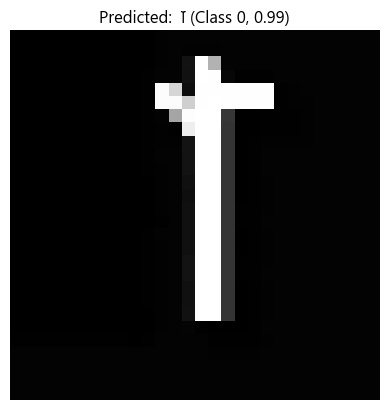

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
model = load_model(r"C:\Users\KIIT\Desktop\minor\ekkush_recognition_model.h5")

# Load the class index to Bengali character mapping from CSV
metadata_path = r"C:\Users\KIIT\Desktop\minor\metaData_img.csv"  # Replace with the actual path
metadata_df = pd.read_csv(metadata_path)

# Create the class_to_char dictionary from the DataFrame
class_to_char = dict(zip(metadata_df['Folder Name'], metadata_df['Char Name']))

# Predict function for a single image (remains the same)
def predict_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(28, 28), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 28, 28, 1)

    # Predict class
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions)

    # Get corresponding Bengali character
    predicted_char = class_to_char.get(predicted_index, "Unknown")

    # Display result
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_char} (Class {predicted_index}, {confidence:.2f})")
    plt.axis('off')
    plt.show()

# Example usage:
predict_image(r"C:\Users\KIIT\Desktop\minor\Screenshot 2025-04-09 054801.png")  # Replace with actual path

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


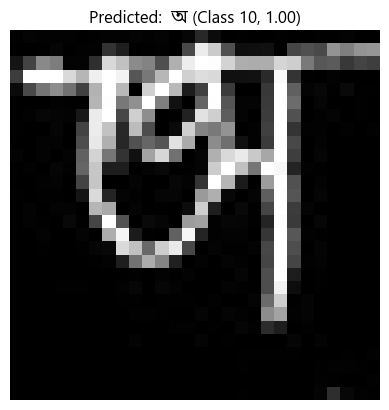

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
model = load_model(r"C:\Users\KIIT\Desktop\minor\ekkush_recognition_model.h5")

# Load the class index to Bengali character mapping from CSV
metadata_path = r"C:\Users\KIIT\Desktop\minor\metaData_img.csv"  # Replace with the actual path
metadata_df = pd.read_csv(metadata_path)

# Create the class_to_char dictionary from the DataFrame
class_to_char = dict(zip(metadata_df['Folder Name'], metadata_df['Char Name']))

# Predict function for a single image (remains the same)
def predict_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(28, 28), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 28, 28, 1)

    # Predict class
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions)

    # Get corresponding Bengali character
    predicted_char = class_to_char.get(predicted_index, "Unknown")

    # Display result
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_char} (Class {predicted_index}, {confidence:.2f})")
    plt.axis('off')
    plt.show()

# Example usage:
predict_image(r"C:\Users\KIIT\Desktop\minor\Test_Img_05.jpg")  # Replace with actual path

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


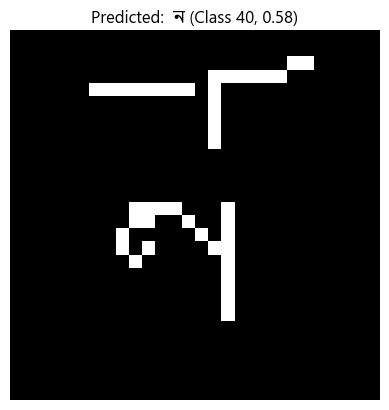

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
model = load_model(r"C:\Users\KIIT\Desktop\minor\ekkush_recognition_model.h5")

# Load the class index to Bengali character mapping from CSV
metadata_path = r"C:\Users\KIIT\Desktop\minor\metaData_img.csv"  # Replace with the actual path
metadata_df = pd.read_csv(metadata_path)

# Create the class_to_char dictionary from the DataFrame
class_to_char = dict(zip(metadata_df['Folder Name'], metadata_df['Char Name']))

# Predict function for a single image (remains the same)
def predict_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(28, 28), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 28, 28, 1)

    # Predict class
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions)

    # Get corresponding Bengali character
    predicted_char = class_to_char.get(predicted_index, "Unknown")

    # Display result
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_char} (Class {predicted_index}, {confidence:.2f})")
    plt.axis('off')
    plt.show()

# Example usage:
predict_image(r"C:\Users\KIIT\Pictures\Screenshots\Screenshot 2025-04-09 144032.png")  # Replace with actual path

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


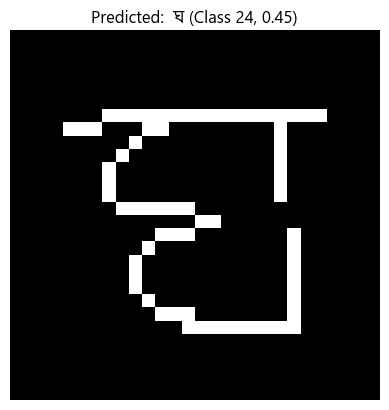

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
model = load_model(r"C:\Users\KIIT\Desktop\minor\ekkush_recognition_model.h5")

# Load the class index to Bengali character mapping from CSV
metadata_path = r"C:\Users\KIIT\Desktop\minor\metaData_img.csv"  # Replace with the actual path
metadata_df = pd.read_csv(metadata_path)

# Create the class_to_char dictionary from the DataFrame
class_to_char = dict(zip(metadata_df['Folder Name'], metadata_df['Char Name']))

# Predict function for a single image (remains the same)
def predict_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(28, 28), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 28, 28, 1)

    # Predict class
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions)

    # Get corresponding Bengali character
    predicted_char = class_to_char.get(predicted_index, "Unknown")

    # Display result
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_char} (Class {predicted_index}, {confidence:.2f})")
    plt.axis('off')
    plt.show()

# Example usage:
predict_image(r"C:\Users\KIIT\Downloads\img4.png")  # Replace with actual path

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


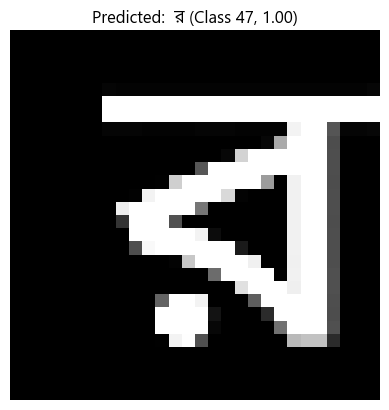

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
model = load_model(r"C:\Users\KIIT\Desktop\minor\ekkush_recognition_model.h5")

# Load the class index to Bengali character mapping from CSV
metadata_path = r"C:\Users\KIIT\Desktop\minor\metaData_img.csv"  # Replace with the actual path
metadata_df = pd.read_csv(metadata_path)

# Create the class_to_char dictionary from the DataFrame
class_to_char = dict(zip(metadata_df['Folder Name'], metadata_df['Char Name']))

# Predict function for a single image (remains the same)
def predict_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(28, 28), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 28, 28, 1)

    # Predict class
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions)

    # Get corresponding Bengali character
    predicted_char = class_to_char.get(predicted_index, "Unknown")

    # Display result
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_char} (Class {predicted_index}, {confidence:.2f})")
    plt.axis('off')
    plt.show()

# Example usage:
predict_image(r"C:\Users\KIIT\Desktop\79.jpg")  # Replace with actual path

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


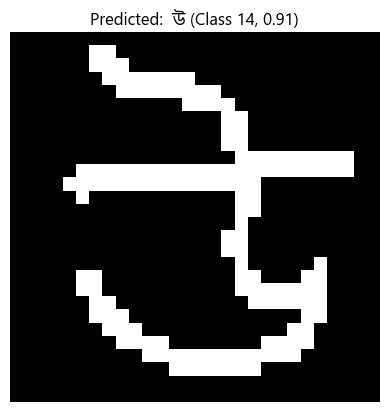

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
model = load_model(r"C:\Users\KIIT\Desktop\minor\ekkush_recognition_model.h5")

# Load the class index to Bengali character mapping from CSV
metadata_path = r"C:\Users\KIIT\Desktop\minor\metaData_img.csv"  # Replace with the actual path
metadata_df = pd.read_csv(metadata_path)

# Create the class_to_char dictionary from the DataFrame
class_to_char = dict(zip(metadata_df['Folder Name'], metadata_df['Char Name']))

# Predict function for a single image (remains the same)
def predict_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(28, 28), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 28, 28, 1)

    # Predict class
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions)

    # Get corresponding Bengali character
    predicted_char = class_to_char.get(predicted_index, "Unknown")

    # Display result
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_char} (Class {predicted_index}, {confidence:.2f})")
    plt.axis('off')
    plt.show()

# Example usage:
predict_image(r"C:\Users\KIIT\Desktop\img8.png")  # Replace with actual path

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


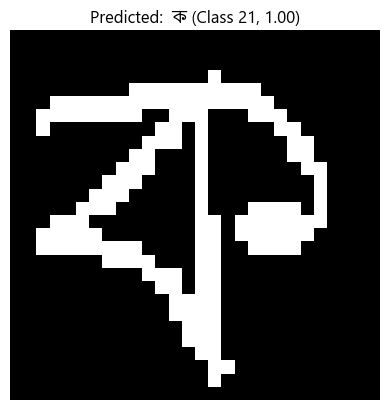

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
model = load_model(r"C:\Users\KIIT\Desktop\minor\ekkush_recognition_model.h5")

# Load the class index to Bengali character mapping from CSV
metadata_path = r"C:\Users\KIIT\Desktop\minor\metaData_img.csv"  # Replace with the actual path
metadata_df = pd.read_csv(metadata_path)

# Create the class_to_char dictionary from the DataFrame
class_to_char = dict(zip(metadata_df['Folder Name'], metadata_df['Char Name']))

# Predict function for a single image (remains the same)
def predict_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(28, 28), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 28, 28, 1)

    # Predict class
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions)

    # Get corresponding Bengali character
    predicted_char = class_to_char.get(predicted_index, "Unknown")

    # Display result
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_char} (Class {predicted_index}, {confidence:.2f})")
    plt.axis('off')
    plt.show()

# Example usage:
predict_image(r"C:\Users\KIIT\Desktop\img7.png")  # Replace with actual path

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


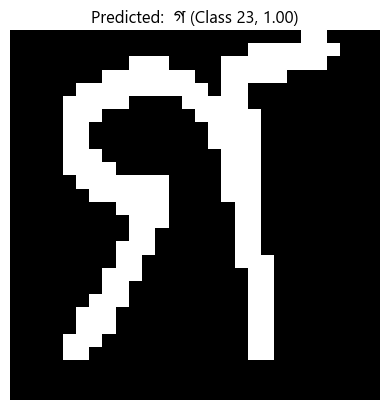

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
model = load_model(r"C:\Users\KIIT\Desktop\minor\ekkush_recognition_model.h5")

# Load the class index to Bengali character mapping from CSV
metadata_path = r"C:\Users\KIIT\Desktop\minor\metaData_img.csv"  # Replace with the actual path
metadata_df = pd.read_csv(metadata_path)

# Create the class_to_char dictionary from the DataFrame
class_to_char = dict(zip(metadata_df['Folder Name'], metadata_df['Char Name']))

# Predict function for a single image (remains the same)
def predict_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(28, 28), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 28, 28, 1)

    # Predict class
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions)

    # Get corresponding Bengali character
    predicted_char = class_to_char.get(predicted_index, "Unknown")

    # Display result
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_char} (Class {predicted_index}, {confidence:.2f})")
    plt.axis('off')
    plt.show()

# Example usage:
predict_image(r"C:\Users\KIIT\Desktop\img9.png")  # Replace with actual path

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


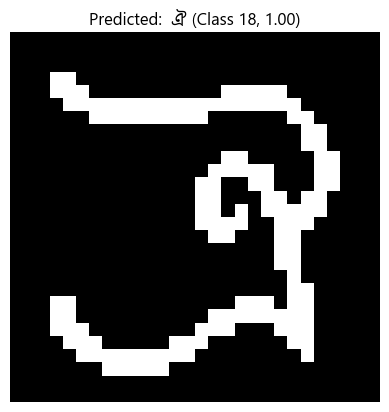

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
model = load_model(r"C:\Users\KIIT\Desktop\minor\ekkush_recognition_model.h5")

# Load the class index to Bengali character mapping from CSV
metadata_path = r"C:\Users\KIIT\Desktop\minor\metaData_img.csv"  # Replace with the actual path
metadata_df = pd.read_csv(metadata_path)

# Create the class_to_char dictionary from the DataFrame
class_to_char = dict(zip(metadata_df['Folder Name'], metadata_df['Char Name']))

# Predict function for a single image (remains the same)
def predict_image(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(28, 28), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 28, 28, 1)

    # Predict class
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions)

    # Get corresponding Bengali character
    predicted_char = class_to_char.get(predicted_index, "Unknown")

    # Display result
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_char} (Class {predicted_index}, {confidence:.2f})")
    plt.axis('off')
    plt.show()

# Example usage:
predict_image(r"C:\Users\KIIT\Desktop\img11.png")  # Replace with actual path